# Lab 3a: Model selection
## Dark matter
We'll use the MAGIC telescope dataset (http://www.openml.org/d/1120). The task is to classifying gamma rays, which consist of high-energy particles. When they hit our atmosphere, they produce chain reactions of other particles called 'showers'. However, similar showers are also produced by other particles (hadrons). We want to be able to detect which ones originate from gamma rays and which ones come from background radiation. To do this, the observed shower patterns are observed and converted into 10 numeric features. You need to detect whether these are gamma rays or background radiation. This is a key aspect of research into dark matter, which is believed to generate such gamma rays. If we can detect where they occur, we can build a map of the origins of gamma radiation, and locate where dark matter may occur in the observed universe. However, we'll first need to accurately detect these gamma rays first.

A quick visualization of the features is shown below. Note that this is not a time series, we just plot the instances in the order they occur in the dataset. The first 12500 or so are examples of signal (gamma), the final 6700 or so are background (hadrons).

In [4]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
from matplotlib import cm

In [5]:
# Download MAGIC Telescope data from OpenML. You can repeat this analysis with any other OpenML classification dataset.
magic = oml.datasets.get_dataset(1120)
X, y, _, _ = magic.get_data(target=magic.default_target_attribute, dataset_format='array'); 
attribute_names = [f.name for i,f in magic.features.items()][:-1][1:]

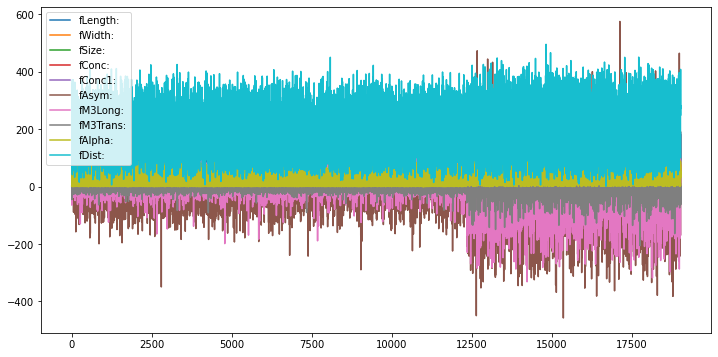

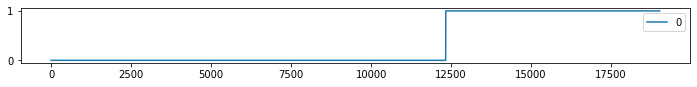

In [6]:
# Quick visualization of the features (top) and the target (bottom)
magic_df = pd.DataFrame(X, columns=attribute_names)
magic_df.plot(figsize=(12,6))
# Also plot the target: 1 = background, 0 = gamma
pd.DataFrame(y).plot(figsize=(12,1));

## Exercise 1: Metrics
Train and evaluate an SVM with RBF kernel (default hyperparameters) using a standard 25% holdout. Report the accuracy, precision, recall, F1 score, and area under the ROC curve (AUC).

Answer the following questions:
* How many of the detected gamma rays are actually real gamma rays?
* How many of all the gamma rays are we detecting?
* How many false positives and false negatives occur?

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

def train_svm(X,y):
    return SVC(kernel='rbf').fit(X, y)

def output_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc_svc = roc_auc_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f'accuracy score: {accuracy}')
    plt.rcParams['figure.dpi'] = 100 
    print(classification_report(y_test, y_pred))
    print(f'Area under ROC curve: {roc_auc_svc}')

    print([key for key in class_report])
    print(conf_matrix)

    print(f"{class_report['0']['precision']:.2f}% of detected gamma rays are actually real gama rays")
    print(f"{class_report['0']['recall']:.2f}% of all actual gamma rays are detected")
    print(f"{conf_matrix[0][1]} false positives and {conf_matrix[1][0]} false negatives")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)
svc_model = train_svm(X_train, y_train)
output_scores(svc_model, X_test, y_test)







accuracy score: 0.8243953732912723
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      3083
           1       0.88      0.58      0.70      1672

    accuracy                           0.82      4755
   macro avg       0.84      0.77      0.79      4755
weighted avg       0.83      0.82      0.81      4755

Area under ROC curve: 0.7687755976205368
['0', '1', 'accuracy', 'macro avg', 'weighted avg']
[[2948  135]
 [ 700  972]]
0.81% of detected gamma rays are actually real gama rays
0.96% of all actual gamma rays are detected
135 false positives and 700 false negatives


## Exercise 2: Preprocessing
SVMs require scaling to perform well. For now, use the following code to scale the data (we'll get back to this in the lab about preprocessing and pipelines). Repeat question 2 on the scaled data. Have the results improved? 

In [27]:
from sklearn.preprocessing import StandardScaler
# Important here is to fit the scaler on the training data alone
# Then, use it to scale both the training set and test set
# This assumes that you named your training set X_train. Adapt if needed.
scaler = StandardScaler().fit(X_train)
Xs_train = scaler.transform(X_train)
Xs_test = scaler.transform(X_test)

svm_model = train_svm(Xs_train, y_train)
output_scores(svm_model, Xs_test, y_test)

accuracy score: 0.8717139852786541
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3083
           1       0.90      0.71      0.80      1672

    accuracy                           0.87      4755
   macro avg       0.88      0.83      0.85      4755
weighted avg       0.88      0.87      0.87      4755

Area under ROC curve: 0.8349653796789618
['0', '1', 'accuracy', 'macro avg', 'weighted avg']
[[2956  127]
 [ 483 1189]]
0.86% of detected gamma rays are actually real gama rays
0.96% of all actual gamma rays are detected
127 false positives and 483 false negatives


The accuracy, area under ROC curve and precision all went up while recall stayed the same. \
The false positives and negatives both went down.

## Exercise 3: Hyperparameter optimization
Use 50 iterations of random search to tune the $C$ and $gamma$ hyperparameters on the scaled training data. Vary both on a log scale (e.g. from 2^-12 to 2^12). Optimize on AUC and use 3 cross-validation (CV) folds for the inner CV to estimate performance. For the outer loop, just use the train-test split you used before (hence, no nested CV). Report the best hyperparameters and the corresponding AUC score. Is it better than the default? Finally, use them to evaluate the model on the held-out test set, for all 5 metrics we used before.

Extra challenge: plot the samples used by the random search ($C$ vs $gamma$)

Note: The reason we don't use a nested CV just yet is because we would need to rebuild the scaled training and test set multiple times. This is tedious, unless we use pipelines, which we'll cover in a future lab.

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_grid = {'C': loguniform(1e-12, 1e4),
             'gamma': loguniform(1e-12, 1e12)}
svm = RandomizedSearchCV(SVC(kernel='rbf'), param_distributions=param_grid, n_iter=50, cv=3, scoring='roc_auc', n_jobs=-1)
svm = svm.fit(Xs_train, y_train)
print(f'best parameters: {svm.best_params_}')
print(f'best mean cv score: {svm.best_score_}')
best_svm = svm.best_estimator_
# train now model with best parameters on full trainset (instead of smaller ones in cross validation)
best_svm = best_svm.fit(Xs_train, y_train)
output_scores(best_svm, Xs_test, y_test)
print(f'default parameters: {svm_model.get_params()}')



best parameters: {'C': 22.567827365266247, 'gamma': 0.27907493620234375}
best mean cv score: 0.9134552112448727
accuracy score: 0.8786540483701367
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      3083
           1       0.89      0.75      0.81      1672

    accuracy                           0.88      4755
   macro avg       0.88      0.85      0.86      4755
weighted avg       0.88      0.88      0.88      4755

Area under ROC curve: 0.8481185215419641
['0', '1', 'accuracy', 'macro avg', 'weighted avg']
[[2932  151]
 [ 426 1246]]
0.87% of detected gamma rays are actually real gama rays
0.95% of all actual gamma rays are detected
151 false positives and 426 false negatives
default parameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking':

## Exercise 4: Threshold calibration
First, plot the Precision-Recall curve for the SVM using the default parameters on the scaled data. Then, calibrate the threshold to find a solution that yields better recall without sacrificing too much precision.

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3083
           1       0.94      0.66      0.77      1672

    accuracy                           0.86      4755
   macro avg       0.89      0.82      0.84      4755
weighted avg       0.87      0.86      0.86      4755



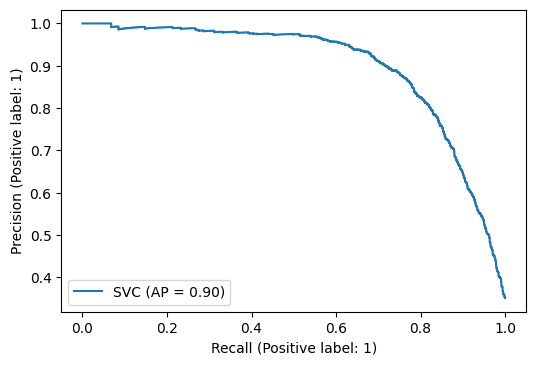

In [41]:
from sklearn.metrics import PrecisionRecallDisplay

def get_recall_prec_from_thresh(model, X, y, threshold=0):
    decision_f = model.decision_function(X)
    pred_from_thresh = np.where(decision_f >= threshold, 1, 0)
    print(classification_report(y, pred_from_thresh))
    
    

PrecisionRecallDisplay.from_estimator(svm_model, Xs_test, y_test)
get_recall_prec_from_thresh(svm_model, Xs_test, y_test, 0.3)


## Exercise 5: Cost function
Assume that a false negative is twice as bad (costly) than a false positive. I.e. we would rather waste time checking gamma ray sources that are not real, than missing an interesting gamma ray source. Use ROC analysis to find the optimal threshold under this assumption.

Finally, let the model make predictions using the optimal threshold and report all 5 scores. Is recall better now? Did we lose a lot of precision?

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3083
           1       0.72      0.87      0.79      1672

    accuracy                           0.83      4755
   macro avg       0.82      0.84      0.82      4755
weighted avg       0.85      0.83      0.84      4755



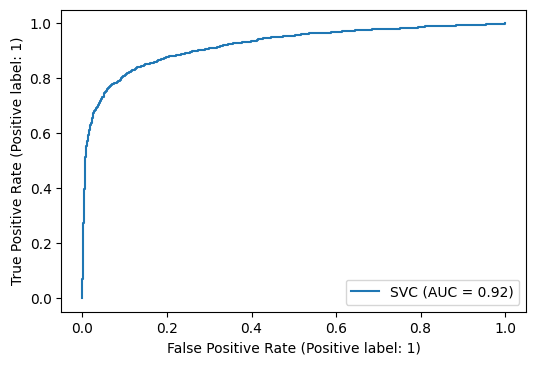

In [55]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(svm_model, Xs_test, y_test)
# note: TPR = recall
# TPR should be high while predicting false positives is less bad (higher FPR)
# to get recall higher, lower the threshold (i.e. get more positive predictions all though they might be FP)

get_recall_prec_from_thresh(svm_model, Xs_test, y_test, threshold=-0.8)
# now on the roc curve we are at recall =0.87 and a FPR between 0.2 and 0.3 which is about twice (1-0.87)
